In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import skmob
from skmob.preprocessing import filtering
from skmob.preprocessing import detection
import folium
import os

In [80]:
path = './DataGPS_Malioboro/filter2_malioboro_des.csv'
df = pd.read_csv(path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38828 entries, 0 to 38827
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   maid            38828 non-null  object 
 1   latitude        38828 non-null  float64
 2   longitude       38828 non-null  float64
 3   datetime_wib    38828 non-null  object 
 4   geometry        38828 non-null  object 
 5   Kelurahan/Desa  38828 non-null  object 
 6   Kecamatan       38828 non-null  object 
 7   Kabupaten       38828 non-null  object 
 8   tanggal         38828 non-null  object 
dtypes: float64(2), object(7)
memory usage: 2.7+ MB


,maid,latitude,longitude,datetime_wib,geometry,Kelurahan/Desa,Kecamatan,Kabupaten,tanggal
0,d60a2068-d7ea-48a7-a363-e3e7e0bd02cb,-7.794847,110.365608,2021-12-01 00:00:35,POINT (110.36560821533205 -7.794847),Kelurahan Suryatmajan,Danurejan,Kota Yogyakarta,2021-12-01
1,3ad1fad6-400a-4ae9-8610-c2d355dcd9f9,-7.794029,110.365944,2021-12-01 00:01:24,POINT (110.3659439086914 -7.794029),Kelurahan Suryatmajan,Danurejan,Kota Yogyakarta,2021-12-01
2,d60a2068-d7ea-48a7-a363-e3e7e0bd02cb,-7.794847,110.365608,2021-12-01 00:01:27,POINT (110.36560821533205 -7.794847),Kelurahan Suryatmajan,Danurejan,Kota Yogyakarta,2021-12-01
3,3ad1fad6-400a-4ae9-8610-c2d355dcd9f9,-7.794029,110.365944,2021-12-01 00:02:55,POINT (110.3659439086914 -7.794029),Kelurahan Suryatmajan,Danurejan,Kota Yogyakarta,2021-12-01
4,3ad1fad6-400a-4ae9-8610-c2d355dcd9f9,-7.794029,110.365944,2021-12-01 00:03:00,POINT (110.3659439086914 -7.794029),Kelurahan Suryatmajan,Danurejan,Kota Yogyakarta,2021-12-01


In [3]:
def count_maid(data):
    filtered_data = data.copy()
    
    # Ganti 'datetime_wib' sesuai nama kolom datetime di data-mu
    filtered_data['datetime_wib'] = pd.to_datetime(filtered_data['datetime_wib'])
    filtered_data['tanggal'] = filtered_data['datetime_wib'].dt.date

    # Hitung jumlah 'maid' unik per hari
    jumlah_maid_unik_per_hari = filtered_data.groupby('tanggal')['maid'].nunique()

    # Print hasilnya
    # print("Jumlah ID user unik: ", data['maid'].nunique())
    maid = data['maid'].nunique()
    return(maid)
#     print(jumlah_maid_unik_per_hari)

In [4]:
def bar_chart(data):
    filtered_data = data.copy()

    # Hapus duplikat 'maid' berdasarkan tanggal
    filtered_data_unique_maid = filtered_data.drop_duplicates(subset=['tanggal', 'maid'])

    # Hitung jumlah unik per hari
    jumlah_unik_per_hari = filtered_data_unique_maid.groupby('tanggal').size()

    # Plotting
    plt.figure(figsize=(10, 6))
    jumlah_unik_per_hari.plot(kind='bar', color='skyblue')
    maid = count_maid(data)
    plt.title(f'Jumlah Data Maid unik per Hari: {maid}')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Data Unik')
    plt.xticks(rotation=75)
    plt.show()

In [5]:
def create_plot(data):
    m = folium.Map(location=[-7.794847, 110.365608], zoom_start=25)

    # Create a PolyLine to connect the points
#     locations = data[['lat', 'lng']].values.tolist()
#     folium.PolyLine(
#         locations=locations,
#         color='red',  # Color of the line
#         weight=2,  # Thickness of the line
#         opacity=1,  # Opacity of the line
#     ).add_to(m)

    # Add CircleMarkers for each point
    for index, row in data.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,  # Marker size
            color="blue",  # Marker color
            fill=True,
            fill_color="blue",  # Fill color of the marker
            fill_opacity=0.7,  # Opacity of the marker fill
            popup=f"User ID: {row['maid']}<br>Latitude: {row['latitude']}<br>Longitude: {row['longitude']}",
        ).add_to(m)
    
    return m

In [6]:
def create_pivot(data):
    df1_1 = data.copy()
    df1_pivot = df1_1['maid'].groupby(df1_1['tanggal']).value_counts()
    pivot = df1_pivot.unstack().fillna(0).astype(int)

    total_counts = pivot.sum(axis=0)
    sorted_columns = total_counts.sort_values(ascending=False).index
    pivot_sorted = pivot[sorted_columns]
    return pivot_sorted

In [7]:
def remove_stops(gps, stops):
    stops_df = stops.copy()
    gps_df = gps.copy()

    # Convert datetime columns to datetime objects
    stops_df['datetime_wib'] = pd.to_datetime(stops_df['datetime_wib'])
    stops_df['leaving_datetime'] = pd.to_datetime(stops_df['leaving_datetime'])
    gps_df['datetime_wib'] = pd.to_datetime(gps_df['datetime_wib'])

    # Iterate through each row in Stops DataFrame
    for index, row in stops_df.iterrows():
        uid = row['maid']
        start_time = row['datetime_wib']
        end_time = row['leaving_datetime']

        # Filter GPS DataFrame based on UID and time range
        filtered_gps_df = gps_df[(gps_df['maid'] == uid) & (gps_df['datetime_wib'] >= start_time) & (gps_df['datetime_wib'] <= end_time)]
        # Remove corresponding rows from GPS DataFrame
        gps_df = gps_df.drop(filtered_gps_df.index)

    # Resulting GPS DataFrame without eliminated data
    print("Number of points dropped from original data: %d" %(len(gps) - len(gps_df)))
    
    return gps_df

In [8]:
def third_preprocessing(df):
    # 1. Noise filtering >200
    df1 = df.copy()

    df1['datetime_wib'].astype(str)
    tdf = skmob.TrajDataFrame(df1, latitude='latitude', longitude='longitude', user_id='maid', datetime='datetime_wib')
    ftdf = filtering.filter(tdf, max_speed_kmh=200.)
    temp = ftdf.copy()
    df1 = pd.DataFrame(temp)
    df1.rename(columns={'uid': 'maid', 'lat': 'latitude', 'lng':'longitude', 'datetime':'datetime_wib'}, inplace=True)

    # 2. Exclude stop points for time threshold <5min and spatial threshold <100meter
    stdf = detection.stay_locations(ftdf, minutes_for_a_stop=5.0, spatial_radius_km=0.1, leaving_time=True)
    temp = stdf.copy()
    stdf_df = pd.DataFrame(temp)
    stdf_df.rename(columns={'uid': 'maid', 'lat': 'latitude', 'lng':'longitude', 'datetime':'datetime_wib'}, inplace=True)

    df2 = remove_stops(df1, stdf_df)    

    return df2

## 1. Noise filtering
We are going to remove the outlier here, for some points that have the velocity of 'the flash' or maybe they were on a flight

In [87]:
df1 = df.copy()

df1['datetime_wib'].astype(str)
tdf = skmob.TrajDataFrame(df1, latitude='latitude', longitude='longitude', user_id='maid', datetime='datetime_wib')
ftdf = filtering.filter(tdf, max_speed_kmh=200.)
temp = ftdf.copy()
df1 = pd.DataFrame(temp)
df1.rename(columns={'uid': 'maid', 'lat': 'latitude', 'lng':'longitude', 'datetime':'datetime_wib'}, inplace=True)

print('Number of points before filtering: %d' %len(df))
print('Number of points after filtering: %d\n' %(len(df1)))

Number of points before filtering: 38828
Number of points after filtering: 38823



In [88]:
print("Unique value for each column:")
print(df1.nunique())
print("\n")

print("Shape before noise filtering: ", df.shape)
print("Shape after noise filtering: ", df1.shape)

Unique value for each column:
maid               4383
latitude           4173
longitude           759
datetime_wib      38460
geometry          11350
Kelurahan/Desa        5
Kecamatan             4
Kabupaten             1
tanggal              31
dtype: int64


Shape before noise filtering:  (38828, 9)
Shape after noise filtering:  (38823, 9)


## 1.1 Explore after noise filtering

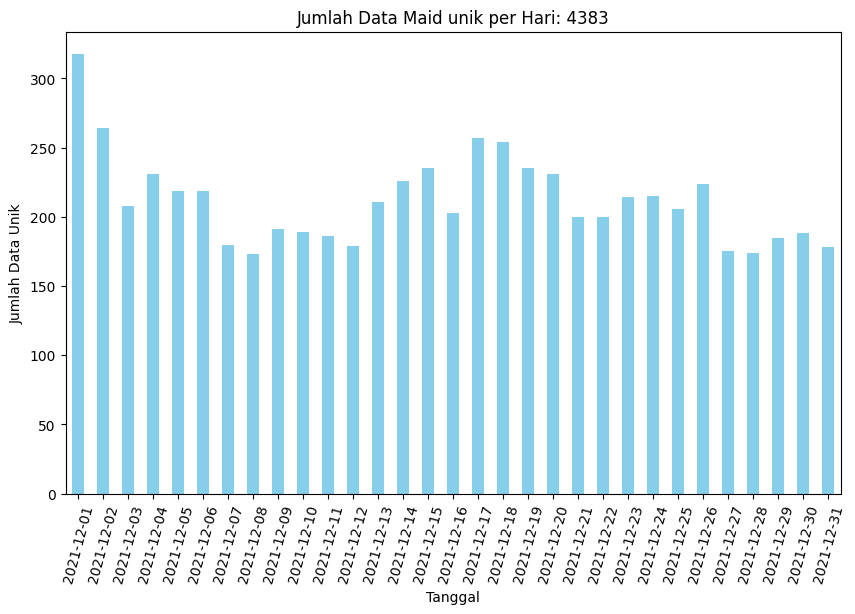

In [89]:
bar_chart(df1)

In [90]:
df1['maid'].value_counts()

9a63fd0e-d363-478a-8136-99b1eb82693f    2245
f501c8a1-e251-4b8c-87fc-9a1a26d2e19d    1983
6065d08e-1b9a-45ed-9042-fc0773b25d3a     775
a2b6a27a-35e9-4735-909b-6cfbafd288ac     551
4a2de4fb-2878-41ae-bc12-2890dc0f62b8     514
                                        ... 
b9f91dc7-e98e-4db6-a1a9-d946e71e8344       2
84085ef1-30fc-44a1-b2db-a28cea80e759       2
b9e3686d-4361-4f35-b5df-e0b208603b65       2
840c5677-2922-47a6-8aaa-0c31e11403de       2
69205336-4054-4a3a-800f-23037bc73e45       2
Name: maid, Length: 4383, dtype: int64

In [91]:
create_pivot(df1)

maid,9a63fd0e-d363-478a-8136-99b1eb82693f,f501c8a1-e251-4b8c-87fc-9a1a26d2e19d,6065d08e-1b9a-45ed-9042-fc0773b25d3a,a2b6a27a-35e9-4735-909b-6cfbafd288ac,4a2de4fb-2878-41ae-bc12-2890dc0f62b8,52875375-e02d-4ada-aaa5-10c79e2ac8f9,07c459f8-7331-479a-a109-0e6e0b419a9e,15c7b94d-a39c-4f55-bb9c-585f6afcddf7,e3b468cd-558b-485a-9ffb-19b307798fdf,5fd88d93-817a-4804-a6cd-3392c125e0a9,...,31e3cb72-7c36-40f8-a5f8-f1e6480f1e83,31f0338b-8ce2-4c4b-9578-cc60073cfaac,84023cc6-9052-4a3c-892f-acd277f5080d,56d58bf2-6bfe-42ff-ab2e-946731bd876b,ba13e423-3e6e-4baa-a9b5-98fa147e5e15,b9f91dc7-e98e-4db6-a1a9-d946e71e8344,84085ef1-30fc-44a1-b2db-a28cea80e759,b9e3686d-4361-4f35-b5df-e0b208603b65,840c5677-2922-47a6-8aaa-0c31e11403de,69205336-4054-4a3a-800f-23037bc73e45
tanggal,,,,,,,,,,,,,,,,,,,,,
2021-12-01,0,34,130,551,0,0,0,0,63,4,...,0,0,0,0,0,0,0,0,0,0
2021-12-02,0,0,285,0,20,0,0,0,125,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-03,0,12,316,0,25,0,0,0,48,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-04,89,18,44,0,13,0,0,0,0,0,...,0,0,2,0,0,0,2,0,0,0
2021-12-05,128,20,0,0,10,0,0,2,3,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-06,76,22,0,0,16,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-07,84,0,0,0,15,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
2021-12-08,0,0,0,0,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-09,0,0,0,0,31,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
plot = df1[(df1['maid'] == '9a63fd0e-d363-478a-8136-99b1eb82693f') & (df1['tanggal'] == '2021-12-29')]
visual = plot.sort_values(by='datetime_wib')
# visual = visual[:10]
visual

,maid,latitude,longitude,datetime_wib,geometry,Kelurahan/Desa,Kecamatan,Kabupaten,tanggal
26005,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79389,110.365189,2021-12-29 13:56:19,POINT (110.3651885986328 -7.79389),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
26006,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79388,110.365189,2021-12-29 13:56:29,POINT (110.3651885986328 -7.79388),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
26007,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79387,110.365189,2021-12-29 13:56:30,POINT (110.3651885986328 -7.7938704),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
26008,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79389,110.365189,2021-12-29 13:56:45,POINT (110.3651885986328 -7.79389),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
26009,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79395,110.365181,2021-12-29 13:57:31,POINT (110.36518096923828 -7.79395),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
...,...,...,...,...,...,...,...,...,...
26208,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79399,110.365288,2021-12-29 22:06:25,POINT (110.36528778076172 -7.79399),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
26209,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79411,110.364738,2021-12-29 22:08:17,POINT (110.36473846435548 -7.79411),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
26210,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79411,110.364731,2021-12-29 22:08:27,POINT (110.36473083496094 -7.79411),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29
26211,9a63fd0e-d363-478a-8136-99b1eb82693f,-7.79390,110.364750,2021-12-29 22:09:39,POINT (110.36475 -7.7939),Kelurahan Sosromenduran,Gedongtengen,Kota Yogyakarta,2021-12-29


In [32]:
create_plot(visual)

## 2. Stop detection
Detect the stay locations (or stops) for each individual in a TrajDataFrame. A stop is detected when the individual spends at least minutes_for_a_stop minutes within a distance stop_radius_factor * spatial_radius km from a given trajectory point.

Based on the paper [4] Traffic Flow Analysis and Prediction Based on GPS Data of Floating Cars.

From their experiment, they set the time threshold value for 5 min, and the spatial threshold value is 100m. So the velocity threshold is set below 5 km/h.

In [92]:
stdf = detection.stay_locations(ftdf, minutes_for_a_stop=5.0, spatial_radius_km=0.1, leaving_time=True)
temp = stdf.copy()
stdf_df = pd.DataFrame(temp)
stdf_df.rename(columns={'uid': 'maid', 'lat': 'latitude', 'lng':'longitude', 'datetime':'datetime_wib'}, inplace=True)

print('Number of stop points: %d\n' %(len(stdf_df)))

Number of stop points: 4029



In [93]:
df2 = remove_stops(df1, stdf_df)

Number of points dropped from original data: 35591


In [94]:
print("Unique value for each column:")
print(df2.nunique())
print("\n")

print("Shape before remove stops: ", df1.shape)
print("Shape after remove stops: ", df2.shape)

Unique value for each column:
maid              1147
latitude           930
longitude          467
datetime_wib      3229
geometry          1362
Kelurahan/Desa       5
Kecamatan            4
Kabupaten            1
tanggal             31
dtype: int64


Shape before remove stops:  (38823, 9)
Shape after remove stops:  (3232, 9)


## 2.1 Explore after remove stops
Not suprised that more than 80% of the records are stop points :(

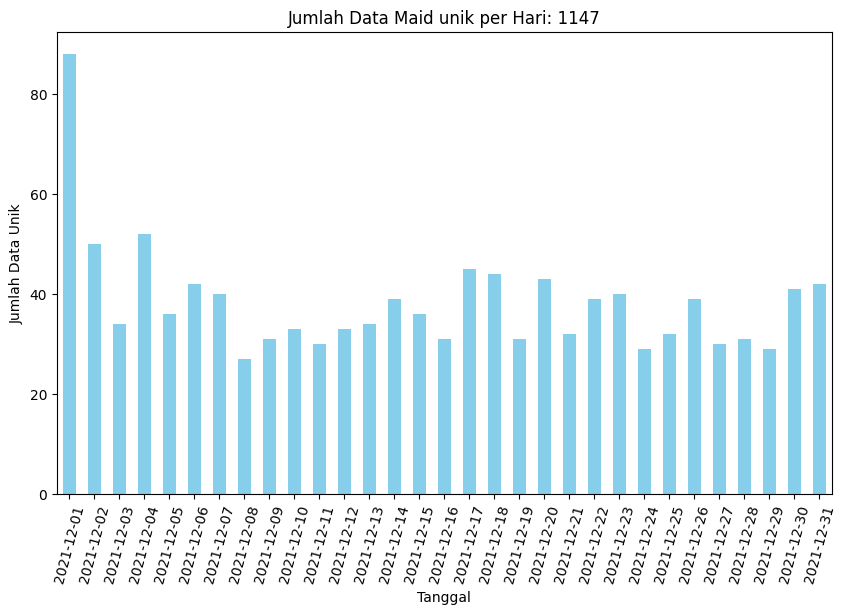

In [95]:
bar_chart(df2)

In [75]:
df2.head()

,maid,latitude,longitude,datetime_wib,geometry,Kelurahan/Desa,Kecamatan,Kabupaten,tanggal
21,004c59b3-b2d0-4369-bd52-022203e04a51,-7.801390,110.365000,2021-12-26 18:42:55,POINT (110.365 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-26
22,004c59b3-b2d0-4369-bd52-022203e04a51,-7.801390,110.364998,2021-12-26 18:43:35,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-26
33,0077b22a-bc83-4dc5-a748-3b16fd4c7893,-7.800784,110.365456,2021-12-22 22:46:11,POINT (110.3654556274414 -7.8007836),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-22
34,0077b22a-bc83-4dc5-a748-3b16fd4c7893,-7.800784,110.365456,2021-12-22 22:48:16,POINT (110.3654556274414 -7.800784),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-22
35,00886369-540d-4f73-b4d3-b8b8cdf5f7fb,-7.801390,110.365000,2021-12-02 19:16:21,POINT (110.365 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-02


In [192]:
plot = df2[(df2['maid'] == 'f501c8a1-e251-4b8c-87fc-9a1a26d2e19d') & (df2['tanggal'] == '2021-12-28')]
visual = plot.sort_values(by='datetime_wib')

In [77]:
plot = df2[df2['tanggal'] == '2021-12-01']
visual = plot.sort_values(by='datetime_wib')

In [78]:
create_plot(visual)

In [207]:
# Menghitung jumlah kemunculan setiap UID pada setiap tanggal
a = df2.copy()

count_per_day = a.groupby(['uid', 'tanggal']).size().reset_index(name='count')

# Mengambil UID yang muncul minimal 2 kali setiap hari
filtered_uids = count_per_day[count_per_day['count'] >= 2]['uid']

# Menghitung total kemunculan setiap UID
total_counts = filtered_uids.value_counts()

# Mendapatkan UID dengan total kemunculan paling banyak
most_frequent_uid = total_counts.idxmax()

print(f"UID dengan kemunculan paling banyak adalah: {most_frequent_uid}")
total_counts = pd.DataFrame(total_counts)
total_counts.sort_values(by='count', ascending=False)

UID dengan kemunculan paling banyak adalah: f501c8a1-e251-4b8c-87fc-9a1a26d2e19d


,count
uid,
f501c8a1-e251-4b8c-87fc-9a1a26d2e19d,5
a36ea4b5-8ee8-4f16-9d80-307e39a7aeba,4
4a2de4fb-2878-41ae-bc12-2890dc0f62b8,3
6065d08e-1b9a-45ed-9042-fc0773b25d3a,3
85ef87a8-f761-46bc-94dc-e0f08789efb4,2
...,...
ffc7892e-923c-49ef-8f3c-486107454e53,1
ffcd6905-e12b-4fb6-bed9-f88380c6ffc8,1
ffd7b1eb-b4f9-4a13-838f-078e53b94d10,1


In [60]:
c = df2.sort_values(by='uid')
c.head(10)

,uid,lat,lng,datetime,geometry,Kelurahan/Desa,Kecamatan,Kabupaten,tanggal
12,0021d9ff-90ea-4f94-88c9-8aa3408378ae,-7.801390,110.364998,2021-12-28 21:55:17,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-28
13,0021d9ff-90ea-4f94-88c9-8aa3408378ae,-7.801390,110.364998,2021-12-28 21:56:22,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-28
14,0021d9ff-90ea-4f94-88c9-8aa3408378ae,-7.801390,110.364998,2021-12-28 21:59:58,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-28
15,0021d9ff-90ea-4f94-88c9-8aa3408378ae,-7.801390,110.364998,2021-12-28 22:02:13,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-28
21,0036b971-96c4-4d06-94f2-570e0b941277,-7.793092,110.366120,2021-12-15 06:22:03,POINT (110.36612 -7.793092),Kelurahan Suryatmajan,Danurejan,Kota Yogyakarta,2021-12-15
22,004c59b3-b2d0-4369-bd52-022203e04a51,-7.801390,110.365000,2021-12-26 18:42:55,POINT (110.365 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-26
23,004c59b3-b2d0-4369-bd52-022203e04a51,-7.801390,110.364998,2021-12-26 18:43:35,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-26
24,00527875-c216-4ca7-9a67-a931fd28c779,-7.801390,110.364998,2021-12-24 05:57:52,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-24
25,00527875-c216-4ca7-9a67-a931fd28c779,-7.801390,110.364998,2021-12-24 06:05:20,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-24
32,0061fba2-4e1f-43ca-84ab-d26681ab6c97,-7.797887,110.365900,2021-12-01 05:29:01,POINT (110.3659 -7.797887),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-01


In [63]:
stdf_df[stdf_df['maid'] == '0021d9ff-90ea-4f94-88c9-8aa3408378ae']

,uid,lat,lng,datetime,geometry,Kelurahan/Desa,Kecamatan,Kabupaten,tanggal,leaving_datetime


## All above preprocessing in one cell

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38828 entries, 0 to 38827
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   maid            38828 non-null  object 
 1   latitude        38828 non-null  float64
 2   longitude       38828 non-null  float64
 3   datetime_wib    38828 non-null  object 
 4   geometry        38828 non-null  object 
 5   Kelurahan/Desa  38828 non-null  object 
 6   Kecamatan       38828 non-null  object 
 7   Kabupaten       38828 non-null  object 
 8   tanggal         38828 non-null  object 
dtypes: float64(2), object(7)
memory usage: 2.7+ MB


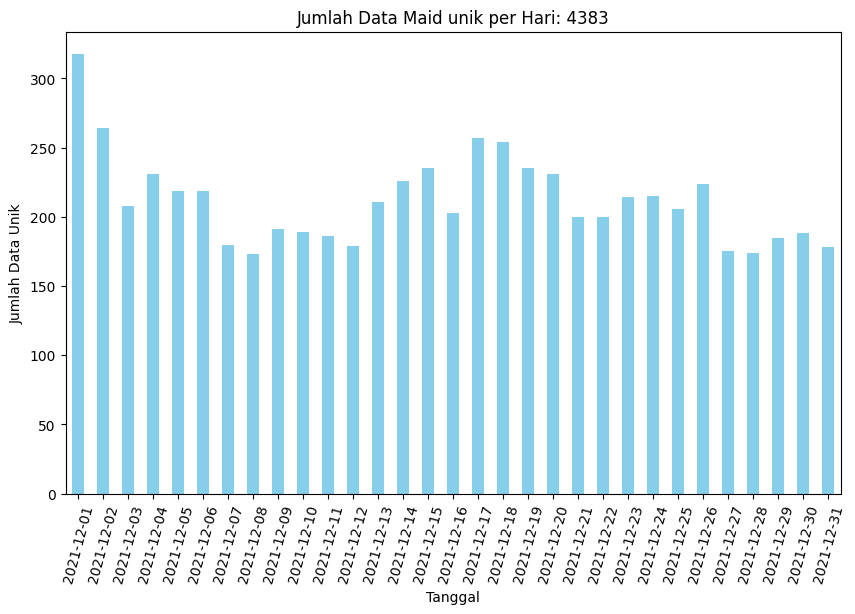

In [12]:
# before preprocessing
path = './DataGPS_Malioboro/filter2_malioboro_des.csv'
df = pd.read_csv(path)
df.info()
bar_chart(df)

Number of points dropped from original data: 35591
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3232 entries, 21 to 38778
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   maid            3232 non-null   object        
 1   latitude        3232 non-null   float64       
 2   longitude       3232 non-null   float64       
 3   datetime_wib    3232 non-null   datetime64[ns]
 4   geometry        3232 non-null   object        
 5   Kelurahan/Desa  3232 non-null   object        
 6   Kecamatan       3232 non-null   object        
 7   Kabupaten       3232 non-null   object        
 8   tanggal         3232 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 252.5+ KB


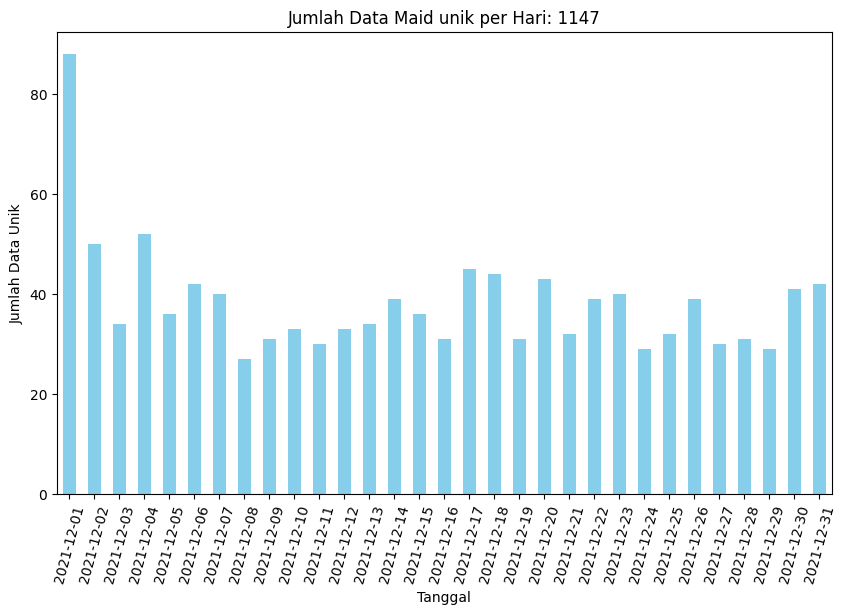

In [13]:
# after preprocessing
df_after = third_preprocessing(df)
df_after.info()
bar_chart(df_after)
filename = path.replace('filter2', 'filter3')

# save filter result to csv
if os.path.exists(path):
    df_after.to_csv(filename, index=False)
else:
    print(f"The file path {path} does not exist.")

In [14]:
a = df_after.sort_values(by=['maid', 'datetime_wib'])
a.head(20)

,maid,latitude,longitude,datetime_wib,geometry,Kelurahan/Desa,Kecamatan,Kabupaten,tanggal
21,004c59b3-b2d0-4369-bd52-022203e04a51,-7.801390,110.365000,2021-12-26 18:42:55,POINT (110.365 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-26
22,004c59b3-b2d0-4369-bd52-022203e04a51,-7.801390,110.364998,2021-12-26 18:43:35,POINT (110.36499786376952 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-26
33,0077b22a-bc83-4dc5-a748-3b16fd4c7893,-7.800784,110.365456,2021-12-22 22:46:11,POINT (110.3654556274414 -7.8007836),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-22
34,0077b22a-bc83-4dc5-a748-3b16fd4c7893,-7.800784,110.365456,2021-12-22 22:48:16,POINT (110.3654556274414 -7.800784),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-22
35,00886369-540d-4f73-b4d3-b8b8cdf5f7fb,-7.801390,110.365000,2021-12-02 19:16:21,POINT (110.365 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-02
36,00886369-540d-4f73-b4d3-b8b8cdf5f7fb,-7.801390,110.365000,2021-12-02 19:18:04,POINT (110.365 -7.80139),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-02
37,00ac9aac-851f-4b1a-b554-cc1f75d02fcd,-7.799030,110.365288,2021-12-22 15:29:32,POINT (110.36528778076172 -7.79903),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-22
38,00ac9aac-851f-4b1a-b554-cc1f75d02fcd,-7.799030,110.365288,2021-12-22 15:29:41,POINT (110.36528778076172 -7.79903),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-22
56,00cba227-d6b8-4518-ab6c-8c3ac3ded8b7,-7.796290,110.364578,2021-12-07 08:34:02,POINT (110.36457824707033 -7.79629),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-07
57,00cba227-d6b8-4518-ab6c-8c3ac3ded8b7,-7.796290,110.364571,2021-12-07 08:34:51,POINT (110.36457061767578 -7.79629),Kelurahan Ngupasan,Gondomanan,Kota Yogyakarta,2021-12-07
